In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

In [128]:
tw = pd.read_csv('base_corr.csv')
#tw_rock =  pd.read_csv('Twitter_Rock.csv')
msj = tw['Twit']
tag = tw['Tag']

#msj_rock =  tw_rock['Message']

In [148]:
size = 80


data_si = [(i.split(),j) for i,j in zip(list(msj)[1:1+size],list(tag)[1:1+size])]

#data_no = [(i.split(),'No Meteorologico') for i in list(msj_rock)[:size]]

data = data_si 

test_si = [(i.split(),j) for i,j in zip(list(msj)[1+size:1+2*size],list(tag)[1+size:1+2*size])]


test_data = test_si 

label_to_ix = { 1: 0, 0: 1 }

In [139]:
word_to_ix = {}
for sent, _ in data + test_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
#print (word_to_ix,len(word_to_ix))

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2

In [149]:
class BoWClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, num_labels, vocab_size):
        
        super(BoWClassifier, self).__init__()

        self.linear = nn.Linear(vocab_size, num_labels)
        
        
    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)
    
    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        for word in sentence:
            vec[word_to_ix[word]] += 1
        return vec.view(1, -1)

    def make_target(label, label_to_ix):
        
        return torch.LongTensor([label_to_ix[label]])
    
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)


In [143]:
NUM_LABELS

2

In [41]:
#print(BoWClassifier.make_bow_vector('me me gusta comer en la cafeteria'.split(),word_to_ix))


#for param in model.parameters():
    #print (param)
    
# To run the model, pass in a BoW vector, but wrapped in an autograd.Variable
sample = data[0]
#print (sample)
bow_vector = BoWClassifier.make_bow_vector(sample[0], word_to_ix)
#print(bow_vector)
log_probs = model(bow_vector)
#print (log_probs.exp())

In [43]:
# Run on test data before we train, just to see a before-and-after
for instance, label in test_data:
    bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
    log_probs = model(bow_vec)
    print (log_probs.exp(), label)
print (next(model.parameters())[:,word_to_ix["lluvia"]]) # Print the matrix column corresponding to "creo"

tensor([[0.4996, 0.5004]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.5524, 0.4476]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4790, 0.5210]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4978, 0.5022]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4516, 0.5484]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4944, 0.5056]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4853, 0.5147]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4870, 0.5130]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.5034, 0.4966]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.4322, 0.5678]], grad_fn=<ExpBackward>) Meteorologico
tensor([[0.5200, 0.4800]], grad_fn=<ExpBackward>) No Meteorologico
tensor([[0.5228, 0.4772]], grad_fn=<ExpBackward>) No Meteorologico
tensor([[0.5229, 0.4771]], grad_fn=<ExpBackward>) No Meteorologico
tensor([[0.5427, 0.4573]], grad_fn=<ExpBackward>) No Meteorologico
tensor([[0.4567, 0.5433]], grad_fn=<ExpBackward>) No Meteorologico
tensor([[0.4756, 0.5244]]

In [150]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Usually you want to pass over the training data several times.
# 100 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.
for epoch in range(100):
    if epoch % 10 == 0: print('Epoch: %i' %epoch)
    for instance, label in data:
        # Step 1. Remember that Pytorch accumulates gradients.  We need to clear them out
        # before each instance
        model.zero_grad()
    
        # Step 2. Make our BOW vector and also we must wrap the target in a Variable
        # as an integer.  For example, if the target is SPANISH, then we wrap the integer
        # 0.  The loss function then knows that the 0th element of the log probabilities is
        # the log probability corresponding to SPANISH
        bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
        target = BoWClassifier.make_target(label, label_to_ix)
    
        # Step 3. Run our forward pass.
        log_probs = model(bow_vec)
    
        # Step 4. Compute the loss, gradients, and update the parameters by calling
        # optimizer.step()
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


 tensor([[0.7617, 0.2383]], grad_fn=<ExpBackward>) 0
 tensor([[0.0024, 0.9976]], grad_fn=<ExpBackward>) 0
 tensor([[0.0664, 0.9336]], grad_fn=<ExpBackward>) 0
 tensor([[0.0020, 0.9980]], grad_fn=<ExpBackward>) 0
 tensor([[0.9628, 0.0372]], grad_fn=<ExpBackward>) 0
 tensor([[0.9803, 0.0197]], grad_fn=<ExpBackward>) 1
 tensor([[0.9288, 0.0712]], grad_fn=<ExpBackward>) 0
 tensor([[0.0045, 0.9955]], grad_fn=<ExpBackward>) 0
 tensor([[0.7173, 0.2827]], grad_fn=<ExpBackward>) 0
 tensor([[0.0023, 0.9977]], grad_fn=<ExpBackward>) 0
 tensor([[0.6250, 0.3750]], grad_fn=<ExpBackward>) 0
 tensor([[0.6936, 0.3064]], grad_fn=<ExpBackward>) 0
 tensor([[0.6626, 0.3374]], grad_fn=<ExpBackward>) 1
 tensor([[0.2965, 0.7035]], grad_fn=<ExpBackward>) 0
 tensor([[0.8798, 0.1202]], grad_fn=<ExpBackward>) 0
 tensor([[0.9445, 0.0555]], grad_fn=<ExpBackward>) 0
 tensor([[0.2007, 0.7993]], grad_fn=<ExpBackward>) 1
 tensor([[0.5586, 0.4414]], grad_fn=<ExpBackward>) 0
 tensor([[0.2385, 0.7615]], grad_fn=<ExpBackwa

<BarContainer object of 3 artists>

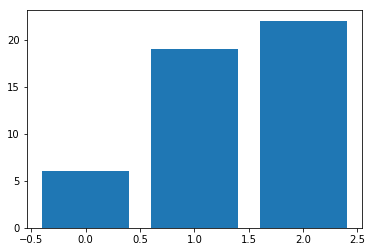

In [155]:
c = [0,0,0]
for instance, label in test_data:
    bow_vec = autograd.Variable(BoWClassifier.make_bow_vector(instance, word_to_ix))
    log_probs = model(bow_vec)
    log_probs_exp = log_probs.exp()
    if bool (log_probs_exp[0][0]>0.5) and (label == 1):
        c[0]+=1
        print ('\033[1;93m' , log_probs_exp , label)
    elif bool (log_probs_exp[0][1]>0.5) and (label == 0):
        c[1]+=1
        print ('\033[1;32m' , log_probs_exp , label)
    else:
        c[2]+=1
        print ('\033[1;31m' , log_probs_exp , label)
 
print('De aciertos Meteorológicos: ', round(c[0]),'%, De No Meteorologicos: ', round(c[1]), '%, de Fallas: ', round(c[2]),'%') 
print(c)
#print ('\033[0m', next(model.parameters())[:,word_to_ix["lluvia"]]) # Index corresponding to Spanish goes up, English goes down!


import matplotlib.pyplot as plt
plt.bar(range(3),c)


In [113]:
instance = 'concierto de Rock en la ciudad'.split()

bow_vec = autograd.Variable(BoWClassifier.make_bow_vector(instance, word_to_ix))
log_probs = model(bow_vec)
log_probs_exp = log_probs.exp()

print(log_probs_exp)

tensor([[0.9668, 0.0332]], grad_fn=<ExpBackward>)
